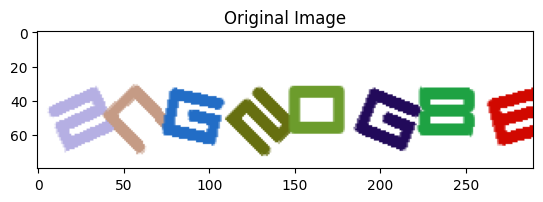

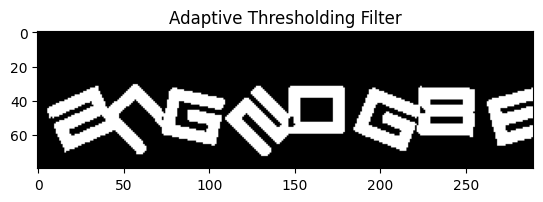

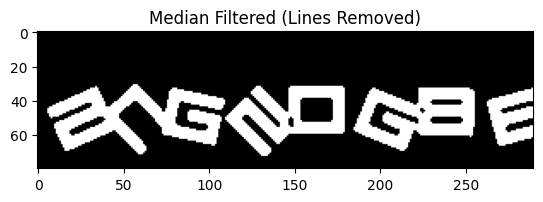

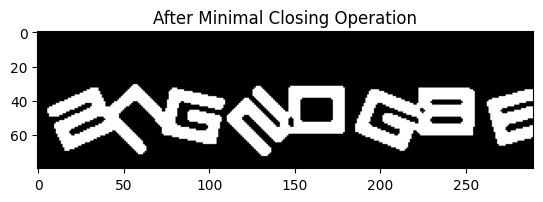

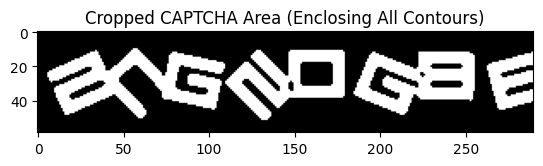

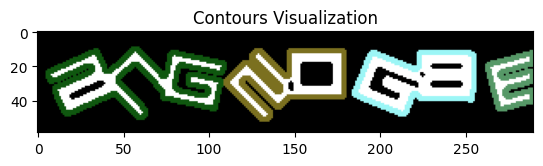

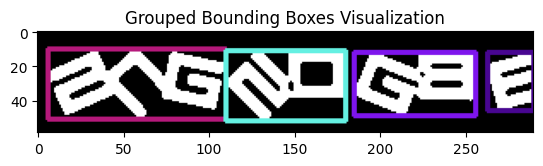

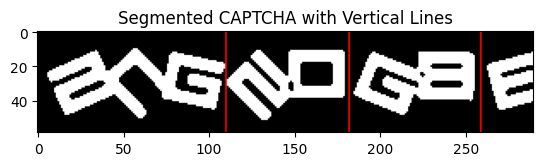

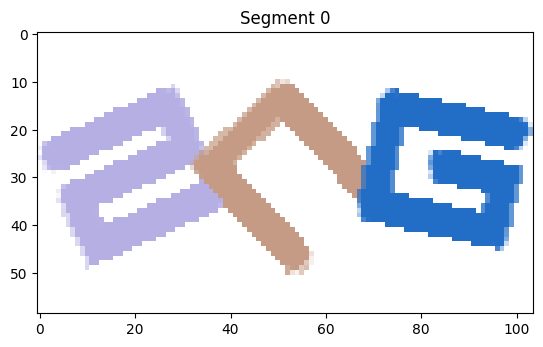

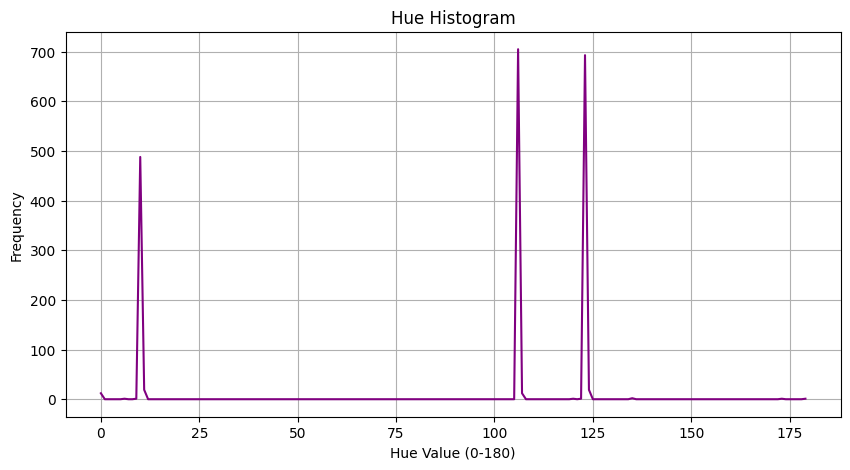

Detected Peaks: [ 10 106 123]


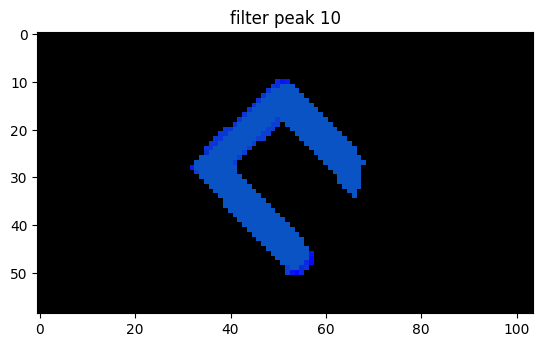

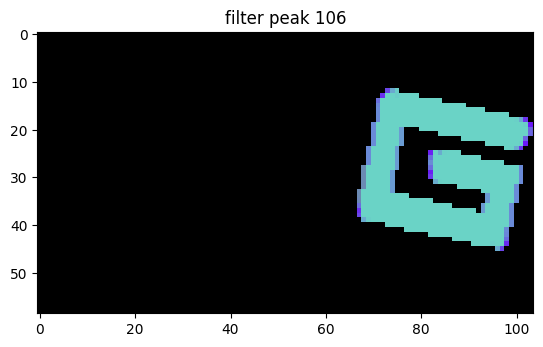

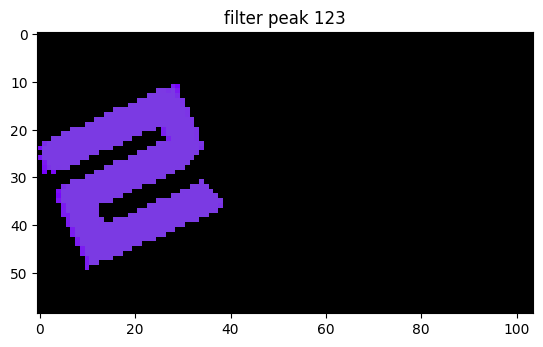

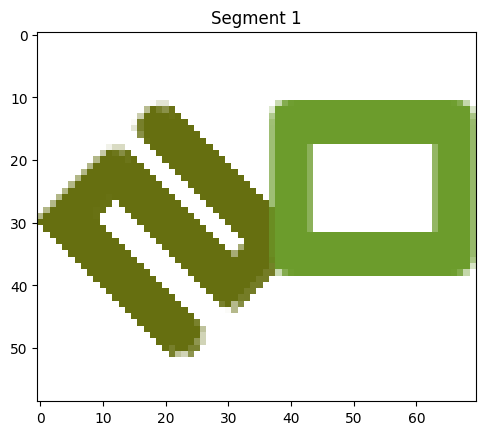

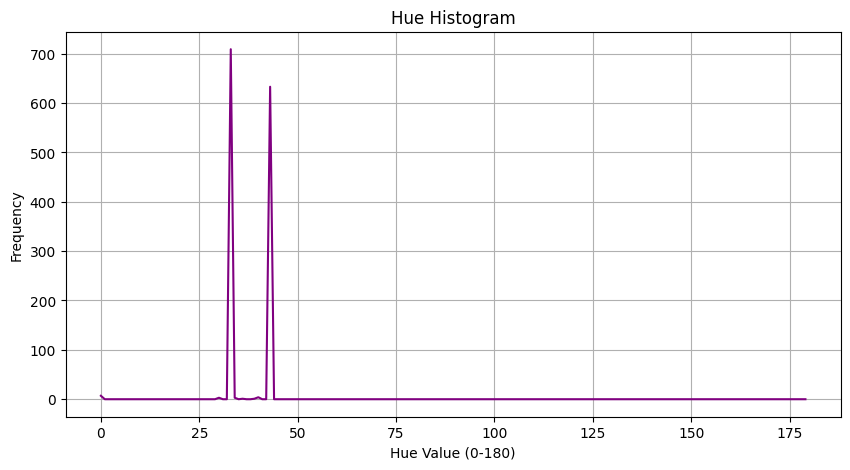

Detected Peaks: [33 43]


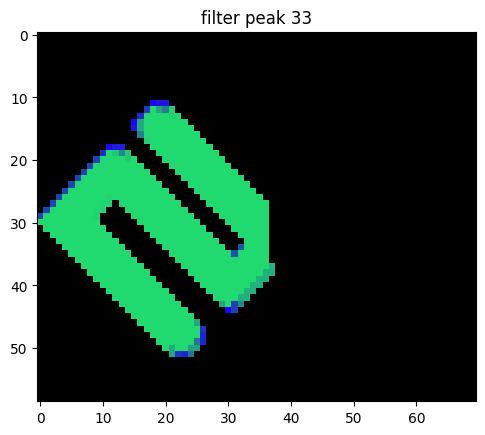

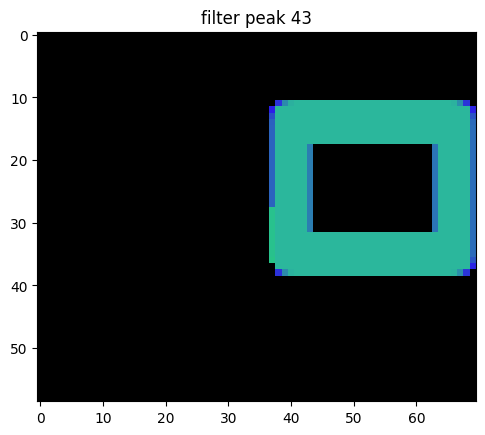

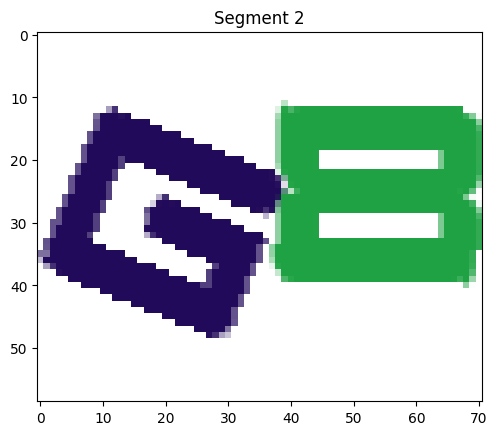

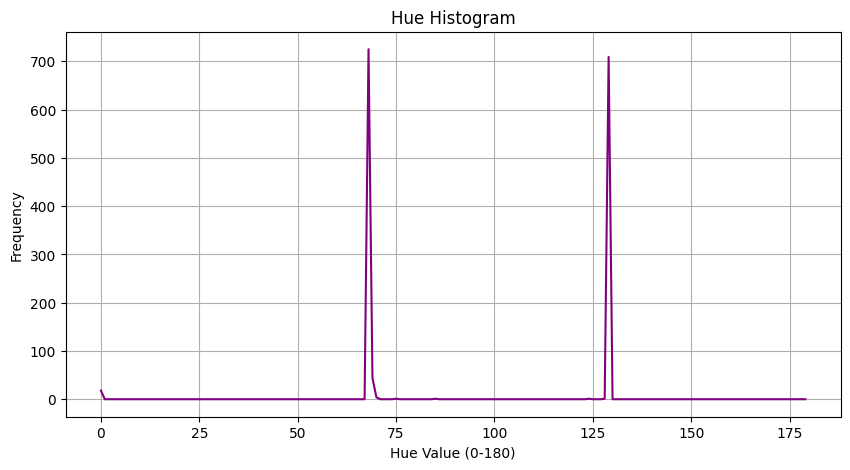

Detected Peaks: [ 68 129]


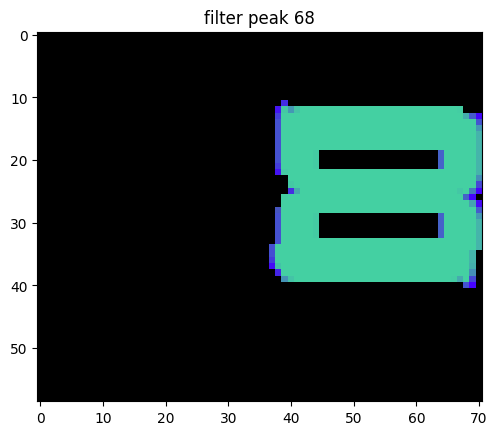

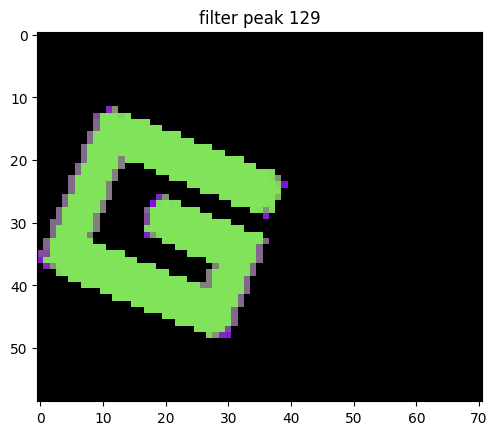

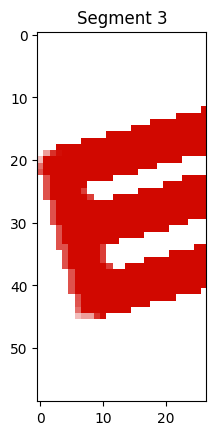

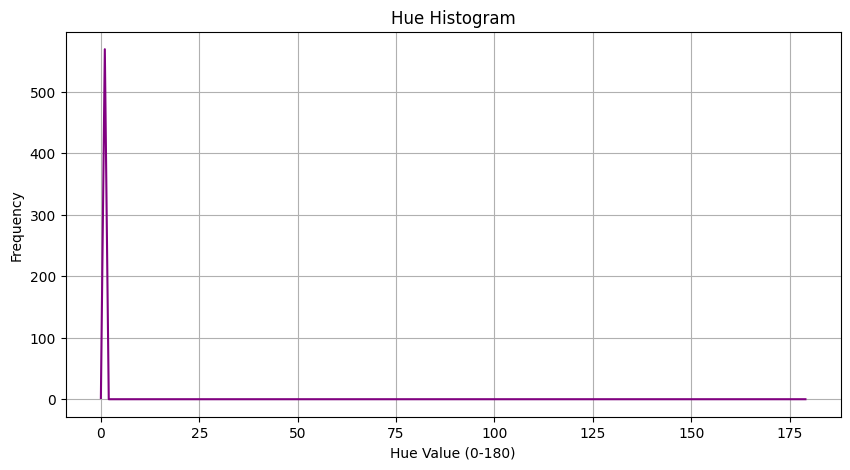

Detected Peaks: [1]


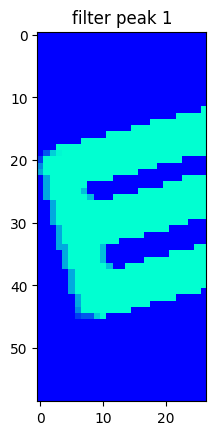

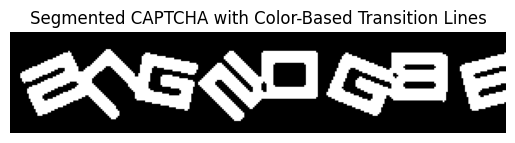

In [14]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the CAPTCHA image
# 7dqtxy
image_path = "train/2cg2og8e-0.png" #"train/2jefvnxe-0.png" #"train/0igt-0.png" #"train/0axhfa-0.png" 
image = cv2.imread(image_path)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.show()

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
adjusted = cv2.equalizeHist(gray)

# Apply adaptive thresholding to enhance character edges
adaptive_filtered = cv2.adaptiveThreshold(adjusted, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                          cv2.THRESH_BINARY_INV, 11, 2)
plt.imshow(adaptive_filtered, cmap='gray')
plt.title('Adaptive Thresholding Filter')
plt.show()

# Apply median filtering to remove lines and smooth the CAPTCHA image
# Adjust the kernel size (e.g., 3, 5, or 7) based on the thickness of lines to be removed
median_filtered = cv2.medianBlur(adaptive_filtered, 3)
plt.imshow(median_filtered, cmap='gray')
plt.title('Median Filtered (Lines Removed)')
plt.show()

# Apply a minimal closing operation
kernel = np.ones((3, 3), np.uint8)  # Small kernel for minimal effect
closed_image = cv2.morphologyEx(median_filtered, cv2.MORPH_OPEN, kernel, iterations=1)
plt.imshow(closed_image, cmap='gray')
plt.title('After Minimal Closing Operation')
plt.show()

# Find contours to detect the main CAPTCHA area
contours, _ = cv2.findContours(closed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# Determine the bounding box that covers all contours
if not contours:
    print("No contours found in the image.")
    exit()

# Get all x and y coordinates from all contours
all_x = []
all_y = []
for contour in contours:
    for point in contour:
        all_x.append(point[0][0])
        all_y.append(point[0][1])

# Find the min and max of x and y coordinates to form a bounding box
x_min, x_max = min(all_x), max(all_x)
y_min, y_max = min(all_y), max(all_y)

pad = 10

height, width = closed_image.shape
x_min = max(0, x_min - pad)
x_max = min(width, x_max + pad)
y_min = max(0, y_min - pad)
y_max = min(height, y_max + pad)

# Crop the main CAPTCHA area based on the bounding box
captcha_area = median_filtered[y_min:y_max, x_min:x_max]
plt.imshow(captcha_area, cmap='gray')
plt.title('Cropped CAPTCHA Area (Enclosing All Contours)')
plt.show()
    
# Find contours in the cropped area to analyze letter positions
contours, _ = cv2.findContours(captcha_area, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

###
contour_visualization = cv2.cvtColor(captcha_area, cv2.COLOR_GRAY2BGR)

# Draw each contour with a unique color for distinction
for i, contour in enumerate(contours):
    color = (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255))
    cv2.drawContours(contour_visualization, [contour], -1, color, 2)

# Display the image with contours visualized
plt.imshow(contour_visualization)
plt.title('Contours Visualization')
plt.show()
# Get bounding boxes for each contour
bounding_boxes = [cv2.boundingRect(contour) for contour in contours]
bounding_boxes = sorted(bounding_boxes, key=lambda x: x[0])  # Sort by x-coordinate

# Group bounding boxes based on 70% overlap
grouped_boxes = []
current_group = bounding_boxes[0]

for i in range(1, len(bounding_boxes)):
    x, y, w, h = bounding_boxes[i]
    prev_x, prev_y, prev_w, prev_h = current_group
    
    # Calculate overlap width
    overlap_width = min(prev_x + prev_w, x + w) - max(prev_x, x)
    
    # Check for 70% overlap of either bounding box
    if overlap_width > 0 and (overlap_width >= 0.7 * w or overlap_width >= 0.7 * prev_w):
        # Merge bounding boxes by extending current group
        x_min = min(prev_x, x)
        x_max = max(prev_x + prev_w, x + w)
        y_min = min(prev_y, y)
        y_max = max(prev_y + prev_h, y + h)
        current_group = (x_min, y_min, x_max - x_min, y_max - y_min)
    else:
        # No significant overlap; add the current group to grouped_boxes and start a new group
        grouped_boxes.append(current_group)
        current_group = bounding_boxes[i]

# Append the last group
grouped_boxes.append(current_group)

# Visualize grouped bounding boxes
grouped_visualization = cv2.cvtColor(captcha_area, cv2.COLOR_GRAY2BGR)
for group in grouped_boxes:
    x, y, w, h = group
    color = (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255))
    cv2.rectangle(grouped_visualization, (x, y), (x + w, y + h), color, 2)

# Display the image with grouped bounding boxes visualized
plt.imshow(grouped_visualization)
plt.title('Grouped Bounding Boxes Visualization')
plt.show()

# Create a copy of the captcha_area to draw vertical lines on
segmented_image = cv2.cvtColor(captcha_area, cv2.COLOR_GRAY2BGR)

# Draw vertical lines between each grouped bounding box
for i in range(1, len(grouped_boxes)):
    # Calculate x-position between grouped bounding boxes
    prev_x = grouped_boxes[i - 1][0] + grouped_boxes[i - 1][2]
    curr_x = grouped_boxes[i][0]
    line_x = (prev_x + curr_x) // 2

    # Draw the vertical line at this position
    cv2.line(segmented_image, (line_x, 0), (line_x, captcha_area.shape[0]), (255, 0, 0), 1)

# Show the segmented image with vertical lines
plt.imshow(segmented_image)
plt.title('Segmented CAPTCHA with Vertical Lines')
plt.show()
# import cv2
# import numpy as np
# from matplotlib import pyplot as plt

# # Assuming `image` is the original color CAPTCHA image, `captcha_area` is the binary mask, and `grouped_boxes` contains bounding boxes

# Convert the original cropped area (color) to HSV for color segmentation
crop = image[y_min:y_max, x_min:x_max]  # Cropped color image for color analysis
segmented_image = cv2.cvtColor(captcha_area, cv2.COLOR_GRAY2BGR)

# Loop through each grouped box to analyze color transitions
for i in range(len(grouped_boxes)):
    # Get the coordinates of the current bounding box
    x, y, w, h = grouped_boxes[i]
    segment = crop[:, x:x + w]  # Crop each section based on bounding box positions
    plt.imshow(cv2.cvtColor(segment, cv2.COLOR_BGR2RGB))
    plt.title(f'Segment {i}')
    plt.show()

    # Convert the segment to HSV and extract channels
    hsv_segment = cv2.cvtColor(segment, cv2.COLOR_BGR2HSV)
    hue_channel = hsv_segment[:, :, 0]
    saturation_channel = hsv_segment[:, :, 1]
    value_channel = hsv_segment[:, :, 2]

    # Create a mask to ignore background
    segment_mask = captcha_area[:, x:x + w]  # Crop the mask to match the segment dimensions
    segment_mask_resized = cv2.resize(segment_mask, (hue_channel.shape[1], hue_channel.shape[0]))  # Ensure size match
    segment_mask_binary = cv2.threshold(segment_mask_resized, 127, 255, cv2.THRESH_BINARY)[1]  # Ensure binary mask

    # Calculate the hue histogram only on the foreground pixels
    hist = cv2.calcHist([hue_channel], [0], segment_mask_binary, [180], [0, 180])
    hist = hist.flatten()

    # Plot the histogram
    plt.figure(figsize=(10, 5))
    plt.plot(hist, color='purple')
    plt.title("Hue Histogram")
    plt.xlabel("Hue Value (0-180)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    # Identify significant peaks in the histogram that indicate color regions
    peak_threshold = 0.20 * max(hist)  # Define a threshold for peak detection
    peaks = np.where(hist > peak_threshold)[0]

    print("Detected Peaks:", peaks)

    # Step 1: Filter out pixels not close to any peak or that are too close to white
    filtered_segment = np.zeros_like(hsv_segment)

    # Apply peak-based filtering to keep only relevant hues
    for peak in peaks:
        # Define a range around each peak (±20 degrees)
        lower_bound = np.array([max(peak - 5, 0)], dtype=np.uint8)
        upper_bound = np.array([min(peak + 5, 179)], dtype=np.uint8)
        
        # Create masks for hues within the peak range and remove near-white pixels
        peak_mask = cv2.inRange(hue_channel, lower_bound, upper_bound)
        kk = cv2.bitwise_and(hsv_segment, hsv_segment, mask=peak_mask)

        plt.imshow(kk)
        plt.title(f"filter peak {peak}")
        # plt.axis('off')
        plt.show()

    # # Detect transitions between peaks
    # height, width = filtered_segment.shape
    # transition_points = []


# Display the final segmented image with color-based vertical lines at cluster boundaries
plt.imshow(segmented_image)
plt.title("Segmented CAPTCHA with Color-Based Transition Lines")
plt.axis('off')
plt.show()
